# Исследование рекомендаций тарифов оператора мобильной связи

Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. «Мегалайн» хочет построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».


**Данные для исследования** — данные о поведении клиентов, которые уже перешли на эти тарифы.

**Цель исследования** - нужно построить модель для задачи классификации, которая выберет подходящий тариф. 

**Ход исследования** - построим модель с максимально большим значением *accuracy* (минимум 0.75). Проверим *accuracy* на тестовой выборке.


**Известно:**

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. 


`сalls` — количество звонков,


`minutes` — суммарная длительность звонков в минутах,


`messages` — количество sms-сообщений,


`mb_used` — израсходованный интернет-трафик в Мб,


`is_ultra` — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

## Общая информация

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from IPython.display import display
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier


!pip install jupyter-black
import jupyter_black

jupyter_black.load()

try:
    data = pd.read_csv("f:/Users/user/Desktop/Learn/project_5/users_behavior.csv")
except:
    data = pd.read_csv("https://code.s3.yandex.net/datasets/users_behavior.csv")

**Ознакомимся с общей информацией о полученном датафрейме.**

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


**В датафрейме 3214 строк и 5 столбцов.**

В каждом столбце такое же количество строк, пропущенных значений не наблюдается.

**Обратимся к статистическим характеристикам числовых данных.**

In [3]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
calls,3214.0,63.038892,33.236368,0.0,40.0000,62.000,82.0000,244.00
minutes,3214.0,438.208787,234.569872,0.0,274.5750,430.600,571.9275,1632.06
messages,3214.0,38.281269,36.148326,0.0,9.0000,30.000,57.0000,224.00
mb_used,3214.0,17207.673836,7570.968246,0.0,12491.9025,16943.235,21424.7000,49745.73
is_ultra,3214.0,0.306472,0.461100,0.0,0.0000,0.000,1.0000,1.00


**Посмотрим первые 10 строк таблицы.**

In [4]:
data.head(10)

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0


**Проверим данные на наличие дубликатов.**

In [5]:
data.duplicated().sum()

0

Дубликаты не выявлены.

**Для визуализации распределения и корреляции между признаками данных построим матрицу диаграмм рассеяния.** 

Она показывает попарные взаимосвязи между целевым признаком (пользователями тарифов «Смарт» или «Ультра») и другими параметрами.

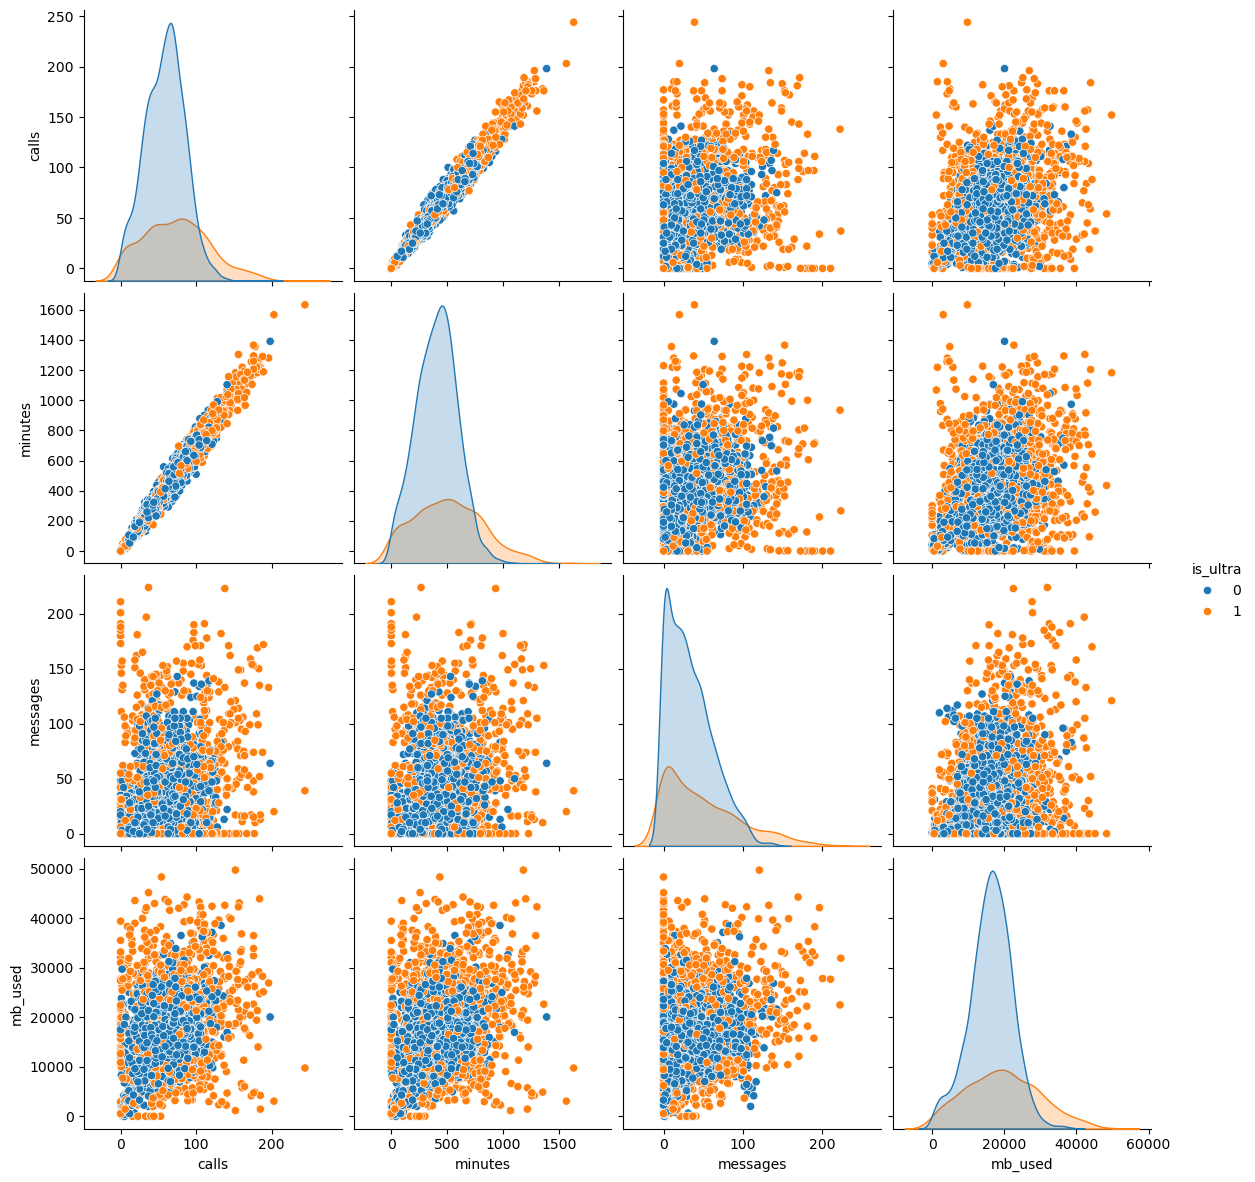

In [6]:
sns.pairplot(data, hue="is_ultra", height=3)
plt.show()

Из графиков видно, что самая очевидная корреляция наблюдается между количеством звонков и их суммарной продолжительностью.
У остальных параметров связь не явная. Максимальные значения параметров заметны у пользователей тарифа «Ультра» (оранжевые точки).
Так же отметим, что пользователей тарифа «Смарт» гораздо больше, чем «Ультра». 

**Выводы:**

Данные в исходном датафрейме готовы к изучению: в них нет пропущенных значений и дубликатов, названия столбцов оформлены верно.

## Разделение данных на выборки

**Для построения моделей потребуются выборки датафрейма. Разделим исходные данные на обучающую, валидационную и тестовую выборки.**

**Признаки:**

В переменной *features* сохраним все признаки, за исключением `is_ultra`, поскольку все они могут влиять на выбор тарифа.


В переменной *target* сохраним целевой признак - `is_ultra`.

In [7]:
# запишем в переменные
features = data.drop(["is_ultra"], axis=1)
target = data["is_ultra"]

In [8]:
# проверим результат
features.shape, target.shape

((3214, 4), (3214,))

**Перейдем к разделению исходных данных на три выборки: обучающую, валидационную и тестовую.**

Размеры тестового и валидационного наборов обычно равны. Исходные данные разбивают в соотношении 3:1:1 (обучающая, валидационная и тестовая выборки соответственно).

Сначала отделим 20% данных на тестовую выборку, она пригодится нам на этапе проверки моделей.

In [9]:
features_train_valid, features_test, target_train_valid, target_test = train_test_split(
    features, target, test_size=0.2, random_state=12345
)

Оставшуюся часть разделим на 1/3 для валидационной выборки и 2/3 для обучающей.

In [10]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features_train_valid, target_train_valid, test_size=0.25, random_state=12345
)

In [11]:
# проверим результат
features_train.shape, features_valid.shape, features_test.shape

((1928, 4), (643, 4), (643, 4))

In [12]:
# проверим результат
target_train.shape, target_valid.shape, target_test.shape

((1928,), (643,), (643,))

**Выводы:**

- сохранили признаки и целевой признак в переменных.
- разделили данные на три выборки: обучающую, валидационную и тестовую в соотношении 60%, 20%, 20%.

## Исследование моделей

### Дерево решений

Постороим модель Дерево решений и посчитаем показатель ее качества на валидационной выборке.

In [13]:
best_result = 0
best_depth = 0
for depth in range(1, 11):  # цикл для max_depth от 1 до 10
    model = DecisionTreeClassifier(
        random_state=12345, max_depth=depth
    )  # cоздаем модель, указав max_depth=depth
    model.fit(features_train, target_train)  # обучим модель
    result = model.score(
        features_valid, target_valid
    )  # найдем предсказания на валидационной выборке
    if result > best_result:
        best_result = result
        best_depth = depth
print(
    "Качество наилучшей модели Дерево решений на валидационной выборке:",
    best_result,
    "при глубине дерева:",
    best_depth,
)

Качество наилучшей модели Дерево решений на валидационной выборке: 0.7744945567651633 при глубине дерева: 7


**Самый высокий показатель accuracy на валидационной выборке 0.77 при max_depth = 7.**

Изменим гиперпараметр *depth* - возьмем диапозон от 11 до 20.

In [14]:
best_result = 0
best_depth = 0
for depth in range(11, 21):  # цикл для max_depth от 11 до 20
    model = DecisionTreeClassifier(
        random_state=12345, max_depth=depth
    )  # cоздаем модель, указав max_depth=depth
    model.fit(features_train, target_train)  # обучим модель
    result = model.score(
        features_valid, target_valid
    )  # найдем предсказания на валидационной выборке
    if result > best_result:
        best_result = result
        best_depth = depth
print(
    "Качество наилучшей модели Дерево решений на валидационной выборке:",
    best_result,
    "при глубине дерева:",
    best_depth,
)

Качество наилучшей модели Дерево решений на валидационной выборке: 0.7589424572317263 при глубине дерева: 11


**В результате изменения диапозона показатель  accuracy не улучшился.**

### Случайный лес

Постороим модель Случайный лес и посчитаем показатель ее качества на валидационной выборке.

In [18]:
best_result = 0
best_depth = 0
best_est = 0
for est in range(1, 11):  # цикл для n_estimators от 1 до 10
    for depth in range(1, 11):  # цикл для max_depth от 1 до 10
        model = RandomForestClassifier(
            random_state=12345, n_estimators=est, max_depth=depth
        )  # обучим модель с заданным количеством деревьев от 1 до 10 и глубиной дерева от 1 до 10
        model.fit(
            features_train, target_train
        )  # обучим модель на тренировочной выборке
        result = model.score(
            features_valid, target_valid
        )  # посчитаем качество модели на валидационной выборке
        if result > best_result:
            best_result = result  #  сохраним наилучшее значение метрики accuracy на валидационных данных
            best_depth = depth
            best_est = est
print(
    "Качество наилучшей модели " "Случайный лес" " на валидационной выборке:",
    best_result,
    "при количестве деревьев:",
    best_est,
    "и глубине дерева:",
    best_depth,
)

Качество наилучшей модели Случайный лес на валидационной выборке: 0.7962674961119751 при количестве деревьев: 3 и глубине дерева: 9


**Самый высокий показатель Accuracy на валидационной выборке модели Случайный лес: 0.80 при значении гиперпараметров n_estimators=3 и max_depth=9.**

Поэкспериментируем с гиперпараметрами: возьмем диапозон *n_estimators* и *max_depth* от 11 до 20.

In [19]:
best_result = 0
best_depth = 0
best_est = 0
for est in range(11, 21):
    for depth in range(11, 21):
        model = RandomForestClassifier(
            random_state=12345, n_estimators=est, max_depth=depth
        )  # обучим модель с заданным количеством деревьев от 1 до 15 и глубиной дерева от 1 до 15
        model.fit(
            features_train, target_train
        )  # обучим модель на тренировочной выборке
        result = model.score(
            features_valid, target_valid
        )  # посчитаем качество модели на валидационной выборке
        if result > best_result:
            best_result = result  #  сохраним наилучшее значение метрики accuracy на валидационных данных
            best_depth = depth
            best_est = est
print(
    "Качество наилучшей модели " "Случайный лес" " на валидационной выборке:",
    best_result,
    "при количестве деревьев:",
    best_est,
    "и глубине дерева:",
    best_depth,
)

Качество наилучшей модели Случайный лес на валидационной выборке: 0.80248833592535 при количестве деревьев: 20 и глубине дерева: 15


**Показатель accuracy тот же: 0.80 при значении гиперпараметров n_estimators=20 и max_depth=15.**

Но большое количество деревьев и их глубина значительно замедляют модель.

### Логистическая регрессия

Постороим модель Логическая регрессия и посчитаем показатель ее качества на валидационной выборке.

In [23]:
model = LogisticRegression(random_state=12345, solver="lbfgs", max_iter=500)
model.fit(features_train, target_train)
model.predict(features_valid)
result = model.score(features_valid, target_valid)
print(
    "Качество наилучшей модели Логическая регрессия на валидационной выборке:",
    result,
)

Качество наилучшей модели Логическая регрессия на валидационной выборке: 0.7262830482115086


**Самый высокий показатель accuracy на валидационной выборке модели Логистическая регрессия: 0.73.**

Поэкспериментируем с гиперпараметром: увеличим количество итераций до 1000.

In [24]:
model = LogisticRegression(random_state=12345, solver="lbfgs", max_iter=1000)
model.fit(features_train, target_train)
model.predict(features_valid)
result = model.score(features_valid, target_valid)
print(
    "Качество наилучшей модели " "Логическая регрессия" " на валидационной выборке:",
    result,
)

Качество наилучшей модели Логическая регрессия на валидационной выборке: 0.7262830482115086


Результат не изменился.

**Выводы:**


- качество наилучшей модели **Дерево решений** на валидационной выборке: **0.77**;
- качество наилучшей модели **Случайный лес** на валидационной выборке: **0.80**;
- качество наилучшей модели **Логическая регрессия** на валидационной выборке: **0.73**.

**Лучший результ показала модель Случайный лес, затем Дерево решений. Логическая регрессия показала наименьший результат.**

**Остановим выбор на модели Дерево решений, поскольку ее качество незначительно отличается от Случайного леса, а скорость работы выше.**

## Проверка модели Дерево решений на тестовой выборке

**Проверим на тестовой выборке модель Дерево решений, которая показала лучший результат с глубиной дерева=7.**

Сравним качество модели на валидационной и тестовой выборках.

**Для увеличения качества модели объединим перед тестированием тренировочную и валидационную выборки.**

In [26]:
features_tr_valid = pd.concat([features_train, features_valid], ignore_index=True)
features_tr_valid

,calls,minutes,messages,mb_used
0,30.0,185.07,34.0,17166.53
1,42.0,290.69,77.0,21507.03
2,41.0,289.83,15.0,22151.73
3,45.0,333.49,50.0,17275.47
4,43.0,300.39,69.0,17277.83
...,...,...,...,...
2566,83.0,539.32,33.0,20967.28
2567,80.0,552.33,23.0,18457.85
2568,111.0,899.74,0.0,26866.61
2569,68.0,493.00,29.0,20021.73


In [27]:
target_tr_valid = pd.concat([target_train, target_valid], ignore_index=True)
target_tr_valid

0       0
1       0
2       0
3       0
4       0
       ..
2566    0
2567    0
2568    0
2569    0
2570    0
Name: is_ultra, Length: 2571, dtype: int64

In [28]:
model = DecisionTreeClassifier(random_state=12345, max_depth=7)
model.fit(features_tr_valid, target_tr_valid)
valid_predictions = model.predict(features_tr_valid)  # код расчёта на обучающей выборке
test_predictions = model.predict(features_test)  # код расчёта на тестовой выборке

print("Accuracy")
print(
    "Валидационная выборка модели Дерево решений:",
    accuracy_score(target_tr_valid, valid_predictions),
)
print(
    "Тестовая выборка модели Дерево решений:",
    accuracy_score(target_test, test_predictions),
)

Accuracy
Валидационная выборка модели Дерево решений: 0.8366394399066511
Тестовая выборка модели Дерево решений: 0.7791601866251944


**Выводы:**


**Модель Дерево решений показала на тестовой выборке долю правильных ответов в 0.78**, что немного выше показателя качества этой модели на валидационной выборке (0.77).


Проверим модель на адекватность с помощью модели случаного числа. 
Сравним нашу модель с ситуацией, когда бы всем клиентам назначили наиболее популярный тариф "Смарт".

Количество верных ответов будет равно количеству клиентов тарифа "Смарт". 

In [33]:
# сохраним в переменную только тариф "Смарт" и посчитаем получившиеся количество
target_random = data[data["is_ultra"] == 0]["is_ultra"].count()

In [34]:
# сохраним в переменную общее количество клиентов
features_random = data["is_ultra"].count()

In [35]:
# посчитаем отношение верных ответов к общему количеству
result = target_random / features_random

In [36]:
result

0.693528313627878

**Модель Дерево решений показала на тестовой выборке 0.79 правильных ответов, а на случайной выборке 0.69, что подтверждает работоспособность выбранной модели.**

**Так же проверим модель на простейшей модели с помощью инструмента DummyClassiffier.**

In [37]:
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=12345)
dummy_clf.fit(features_train, target_train)
result_dummy_valid = dummy_clf.score(features_valid, target_valid)
result_dummy_test = dummy_clf.score(features_test, target_test)

print("Accuracy")
print("Значение по валидационной выборке:", result_dummy_valid)
print("Значение по тестовой выборке:", result_dummy_test)

Accuracy
Значение по валидационной выборке: 0.6889580093312597
Значение по тестовой выборке: 0.6951788491446346


## Общие выводы

**В ходе исследования данных о поведении клиентов мобильного оператора «Мегалайн»:**


- были загружены и изучены данные о пользователях мобильного оператора;
- данные были разбиты на три выборки: обучающую, валидационную и тестовую;
- построены три модели машинного обучения: Дерево решений, Случайный лес и Логическая регрессия;
- качество моделей проверено на валидационной выборке с изменением гиперпараметров;
- качество выбранной модели проверено на тестовой выборке;
- удалось достичь accuracy не меньше 0.75.

**Исследование показало, что модель Дерево решений дала наиболее высокий показатель качества (верных ответов) - 0.79. Именно ее следует рекомендовать оператору «Мегалайн» для построения системы, способной проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».**